# Trabalho 2 da disciplina de APL
Integrantes do grupo:
* Daniel Brai Gonzales Marcos
* Giovanna Nascimento Antonieti
* Priscila Marques de Oliveira

# Importação das bibliotecas

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import pandas as pd
import os
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2

In [2]:
tf.__version__

'2.5.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Metal device set to: Apple M1
1 Physical GPUs, 1 Logical GPUs


2022-06-16 09:33:07.183364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-16 09:33:07.184307: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 1. Dataset 

## 1.1 Carregando os conjuntos de dados e rótulos

In [5]:
# train
dataset_df_train = pd.read_csv('./dataset/train.csv')

# test
dataset_df_test = pd.read_csv('./dataset/test.csv')
dataset_folder ='./dataset/imgs'
class_folders = sorted(os.listdir(dataset_folder))
n_samples=[]
print(class_folders)
print(f'Number of class: {len(class_folders)}')

for class_folder in class_folders:
    full_class_folder = os.path.join(dataset_folder, class_folder)
    
    class_img_filenames = os.listdir(full_class_folder)
    n_samples.append(len(class_img_filenames))
    print(f'Number of Images for Class "{class_folder}": {len(class_img_filenames)}')

['Adam Sandler', 'Alec Baldwin', 'Angelina Jolie', 'Anna Kournikova', 'Ashton Kutcher', 'Avril Lavigne', 'Barack Obama', 'Ben Affleck', 'Beyonce Knowles', 'Brad Pitt', 'Cameron Diaz', 'Cate Blanchett', 'Charlize Theron', 'Christina Ricci', 'Claudia Schiffer', 'Clive Owen', 'Colin Farrell', 'Colin Powell', 'Cristiano Ronaldo', 'Daniel Craig', 'Daniel Radcliffe', 'David Beckham', 'David Duchovny', 'Denise Richards', 'Drew Barrymore', 'Dustin Hoffman', 'Ehud Olmert', 'Eva Mendes', 'Faith Hill', 'George Clooney', 'Gordon Brown', 'Gwyneth Paltrow', 'Halle Berry', 'Harrison Ford', 'Hugh Jackman', 'Hugh Laurie', 'Jack Nicholson', 'Jennifer Aniston', 'Jennifer Lopez', 'Jennifer Love Hewitt', 'Jessica Alba', 'Jessica Simpson', 'Joaquin Phoenix', 'John Travolta', 'Julia Roberts', 'Julia Stiles', 'Kate Moss', 'Kate Winslet', 'Katherine Heigl', 'Keira Knightley', 'Kiefer Sutherland', 'Leonardo DiCaprio', 'Lindsay Lohan', 'Mariah Carey', 'Martha Stewart', 'Matt Damon', 'Meg Ryan', 'Meryl Streep', '

In [6]:
print(f'Mínimo: {min(n_samples)}')
print(f'Máximo: {max(n_samples)}')
n_samples=max(n_samples)

Mínimo: 100
Máximo: 367


## Carregando os rótulos de cada imagem

In [7]:
import random

img_full_paths = []
img_classes = []

# OPTIONAL: just to get the same selected images
random.seed(42)

for class_folder in sorted(os.listdir(dataset_folder)):
    print(f'Class: {class_folder}') 
    
    # translated class
    img_class = class_folder
    
    # get the full class folder pathname
    full_class_folder = os.path.join(dataset_folder, class_folder)
    
    # get all image filenames (without their parent dir) for the current class/animal
    class_img_filenames = sorted(os.listdir(full_class_folder))
    
    
    # undersampling from scratch
    random.shuffle(class_img_filenames)
    class_img_filenames = class_img_filenames[:]
    print(f'Number of images: {len(class_img_filenames)}')
    
    for img_filename in class_img_filenames:
        full_img_path = os.path.join(full_class_folder, img_filename)
        
        img_full_paths.append(full_img_path)
        img_classes.append(img_class)
    
    print()

Class: Adam Sandler
Number of images: 108

Class: Alec Baldwin
Number of images: 103

Class: Angelina Jolie
Number of images: 214

Class: Anna Kournikova
Number of images: 171

Class: Ashton Kutcher
Number of images: 101

Class: Avril Lavigne
Number of images: 299

Class: Barack Obama
Number of images: 268

Class: Ben Affleck
Number of images: 117

Class: Beyonce Knowles
Number of images: 126

Class: Brad Pitt
Number of images: 300

Class: Cameron Diaz
Number of images: 246

Class: Cate Blanchett
Number of images: 160

Class: Charlize Theron
Number of images: 195

Class: Christina Ricci
Number of images: 143

Class: Claudia Schiffer
Number of images: 122

Class: Clive Owen
Number of images: 134

Class: Colin Farrell
Number of images: 145

Class: Colin Powell
Number of images: 112

Class: Cristiano Ronaldo
Number of images: 168

Class: Daniel Craig
Number of images: 168

Class: Daniel Radcliffe
Number of images: 246

Class: David Beckham
Number of images: 187

Class: David Duchovny
Numb

In [8]:
import pandas as pd

dataset_df = pd.DataFrame({
    'image_pathname': img_full_paths,
    'class': img_classes
})

dataset_df

,image_pathname,class
0,./dataset/imgs/Adam Sandler/277.jpg,Adam Sandler
1,./dataset/imgs/Adam Sandler/134.jpg,Adam Sandler
2,./dataset/imgs/Adam Sandler/108.jpg,Adam Sandler
3,./dataset/imgs/Adam Sandler/3.jpg,Adam Sandler
4,./dataset/imgs/Adam Sandler/84.jpg,Adam Sandler
...,...,...
13833,./dataset/imgs/Zac Efron/461.jpg,Zac Efron
13834,./dataset/imgs/Zac Efron/326.jpg,Zac Efron
13835,./dataset/imgs/Zac Efron/393.jpg,Zac Efron
13836,./dataset/imgs/Zac Efron/138.jpg,Zac Efron


## 1.2 Criando os conjuntos de treino e teste com rótulos

In [9]:
imgs = []
classes = []
for i in dataset_df_train['image_pathname']:
    data = dataset_df.loc[dataset_df['image_pathname'] == './dataset/'+i]
    imgs.append(data.iat[0,0])
    classes.append(data.iat[0,1])
    
df_train = pd.DataFrame({
    'image_pathname': imgs,
    'class': classes
})

df_train

,image_pathname,class
0,./dataset/imgs/Adam Sandler/277.jpg,Adam Sandler
1,./dataset/imgs/Adam Sandler/136.jpg,Adam Sandler
2,./dataset/imgs/Adam Sandler/198.jpg,Adam Sandler
3,./dataset/imgs/Adam Sandler/234.jpg,Adam Sandler
4,./dataset/imgs/Adam Sandler/202.jpg,Adam Sandler
...,...,...
12173,./dataset/imgs/Zac Efron/120.jpg,Zac Efron
12174,./dataset/imgs/Zac Efron/476.jpg,Zac Efron
12175,./dataset/imgs/Zac Efron/379.jpg,Zac Efron
12176,./dataset/imgs/Zac Efron/323.jpg,Zac Efron


In [10]:
imgs = []
classes = []
for i in dataset_df_test['image_pathname']:
    data = dataset_df.loc[dataset_df['image_pathname'] == './dataset/'+i]
    imgs.append(data.iat[0,0])
    classes.append(data.iat[0,1])
    
df_test = pd.DataFrame({
    'image_pathname': imgs,
    'class': classes
})

df_test

,image_pathname,class
0,./dataset/imgs/Adam Sandler/34.jpg,Adam Sandler
1,./dataset/imgs/Adam Sandler/236.jpg,Adam Sandler
2,./dataset/imgs/Adam Sandler/127.jpg,Adam Sandler
3,./dataset/imgs/Adam Sandler/111.jpg,Adam Sandler
4,./dataset/imgs/Adam Sandler/216.jpg,Adam Sandler
...,...,...
1655,./dataset/imgs/Zac Efron/240.jpg,Zac Efron
1656,./dataset/imgs/Zac Efron/68.jpg,Zac Efron
1657,./dataset/imgs/Zac Efron/124.jpg,Zac Efron
1658,./dataset/imgs/Zac Efron/283.jpg,Zac Efron


## 1.3 Data augmentation + Label encoder

367 imagens por classe

In [11]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
         tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
         tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
         tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)])

In [12]:
X_train =[]
y_train = []
unique_classes=np.unique(df_train['class'])
for i in unique_classes:
    images = dataset_df.loc[dataset_df['class'] == i]['image_pathname']
    print(f'Loading images for class: {i}')
    imgClass, =np.where(unique_classes==i)
    X_class= []
    for img in images:
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        X_class.append(image)
        y_train.append(imgClass[0])
    imgs.append(images)
    print(f'Starting data augmentation...')
    while len(X_class)<n_samples:
        index = np.random.choice(images)
        image = cv2.imread(img)
        image = tf.expand_dims(image, 0)
        augmented_image = data_augmentation(image)
        X_class.append(augmented_image[0])
        y_train.append(imgClass[0])
    print(f'Data augmentation finished\n\n')
    X_train.extend(X_class)

Loading images for class: Adam Sandler
Starting data augmentation...
Data augmentation finished


Loading images for class: Alec Baldwin
Starting data augmentation...
Data augmentation finished


Loading images for class: Angelina Jolie
Starting data augmentation...
Data augmentation finished


Loading images for class: Anna Kournikova
Starting data augmentation...
Data augmentation finished


Loading images for class: Ashton Kutcher
Starting data augmentation...
Data augmentation finished


Loading images for class: Avril Lavigne
Starting data augmentation...
Data augmentation finished


Loading images for class: Barack Obama
Starting data augmentation...
Data augmentation finished


Loading images for class: Ben Affleck
Starting data augmentation...
Data augmentation finished


Loading images for class: Beyonce Knowles
Starting data augmentation...
Data augmentation finished


Loading images for class: Brad Pitt
Starting data augmentation...
Data augmentation finished


Loading image

Data augmentation finished




In [13]:
print(f'Images: {len(X_train)}')
print(f'Labels : {len(y_train)}')

Images: 30461
Labels : 30461


In [14]:
X_test =[]
y_test =[]

for i in df_test.image_pathname:
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_test.append(image)
    classImage = df_test.loc[df_test['image_pathname'] == i].iat[0,1]
    imgClass, = np.where(unique_classes==classImage)
    y_test.append(imgClass[0])

In [15]:
print(f'Images: {len(X_test)}')
print(f'Labels : {len(y_test)}')

Images: 1660
Labels : 1660


In [16]:
print(f'Menor valor: {min(y_train)}')
print(f'Maior valor: {max(y_train)}')

Menor valor: 0
Maior valor: 82


## 1.4 Feature scaling

In [17]:
#feature scaling
X_train = np.array(X_train)/255.0
X_test = np.array(X_test)/255.0

## 1.5 Separando o conjunto de validação

In [18]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [20]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train (classes): {np.unique(y_train)}')
print(f'y_train.shape: {y_train.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

X_train.shape: (24368, 100, 100, 3)
y_train (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
y_train.shape: (24368,)
Min. value of X_train: 0.0
Max. value of X_train: 1.0



In [21]:
print(f'X_val.shape: {X_val.shape}')
print(f'y_val (classes): {np.unique(y_val)}')
print(f'y_val.shape: {y_val.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_val: {X_val.min()}')
print(f'Max. value of X_val: {X_val.max()}\n')

X_val.shape: (6093, 100, 100, 3)
y_val (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
y_val.shape: (6093,)
Min. value of X_val: 0.0
Max. value of X_val: 1.0



In [22]:
print(f'X_test.shape: {X_test.shape}')
print(f'y_test (classes): {np.unique(y_test)}')
print(f'y_test.shape: {y_test.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_test: {X_test.min()}')
print(f'Max. value of X_test: {X_test.max()}\n')

X_test.shape: (1660, 100, 100, 3)
y_test (classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
y_test.shape: (1660,)
Min. value of X_test: 0.0
Max. value of X_test: 1.0



## 1.6 Salvando os numpy arrays já processados

In [23]:
out_dir = './dataset/preprocessed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

np.save(os.path.join(out_dir, 'train_data.npy'), X_train)
np.save(os.path.join(out_dir, 'train_labels.npy'), y_train)

np.save(os.path.join(out_dir, 'val_data.npy'), X_val)
np.save(os.path.join(out_dir, 'val_labels.npy'), y_val)

np.save(os.path.join(out_dir, 'test_data.npy'), X_test)
np.save(os.path.join(out_dir, 'test_labels.npy'), y_test)

# 2. Modelos

### 2.0.1 Carregando os dados já processados

In [8]:
X_train = np.load('./dataset/preprocessed/train_data.npy')
y_train = np.load('./dataset/preprocessed/train_labels.npy')

X_val = np.load('./dataset/preprocessed/val_data.npy')
y_val = np.load('./dataset/preprocessed/val_labels.npy')

X_test = np.load('./dataset/preprocessed/test_data.npy')
y_test = np.load('./dataset/preprocessed/test_labels.npy')

In [24]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

## 2.1 Modelo n.1: 1 bloco VGG com SGD

### 2.1.1 Criação do modelo

In [25]:
model_vgg1 = Sequential(layers=[
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001), input_shape=(100,100,3)),
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(83, activation='softmax')
])
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, )
model_vgg1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [26]:
model_vgg1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 80000)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               10240128  
_________________________________________________________________
dense_1 (Dense)              (None, 83)               

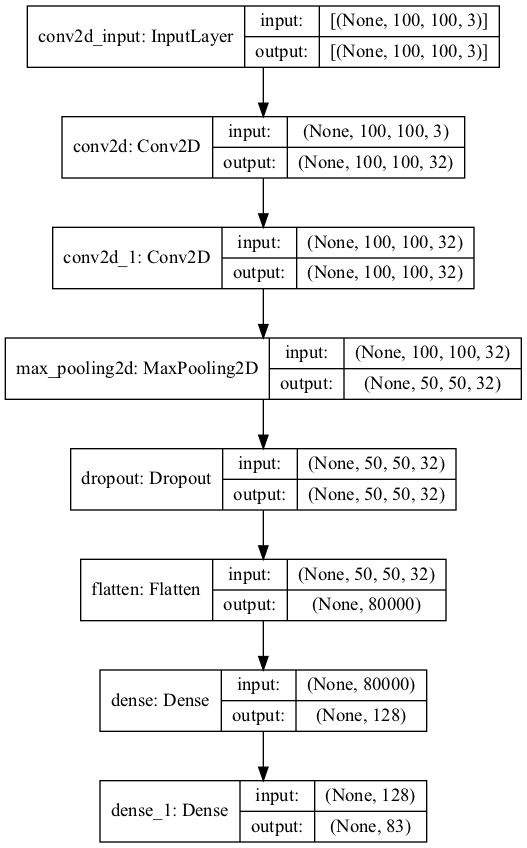

In [27]:
from tensorflow.keras.utils import plot_model
# vertical
plot_model(model_vgg1, show_shapes=True)

### 2.1.2 Treinamento

In [28]:
history = None
with tf.device('/GPU:0'):
    history = model_vgg1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

2022-06-16 09:56:38.814089: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-16 09:56:38.822207: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2022-06-16 09:56:41.984407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - ETA: 0s - loss: 2.8426 - accuracy: 0.3904

2022-06-16 09:57:43.421687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - 71s 86ms/step - loss: 2.8426 - accuracy: 0.3904 - val_loss: 2.1919 - val_accuracy: 0.5408
Epoch 2/100
762/762 [==============================] - 58s 75ms/step - loss: 2.1073 - accuracy: 0.5529 - val_loss: 2.0493 - val_accuracy: 0.5544
Epoch 3/100
762/762 [==============================] - 58s 76ms/step - loss: 1.8810 - accuracy: 0.5715 - val_loss: 1.8621 - val_accuracy: 0.5698
Epoch 4/100
762/762 [==============================] - 58s 76ms/step - loss: 1.6795 - accuracy: 0.5981 - val_loss: 1.6346 - val_accuracy: 0.6032
Epoch 5/100
762/762 [==============================] - 58s 76ms/step - loss: 1.3549 - accuracy: 0.6659 - val_loss: 1.4234 - val_accuracy: 0.6609
Epoch 6/100
762/762 [==============================] - 58s 76ms/step - loss: 1.0219 - accuracy: 0.7435 - val_loss: 1.2633 - val_accuracy: 0.7028
Epoch 7/100
762/762 [==============================] - 59s 77ms/step - loss: 0.7233 - accuracy: 0.8189 - val_loss: 1.3629 - val_accuracy: 0.70

Text(0, 0.5, 'Score')

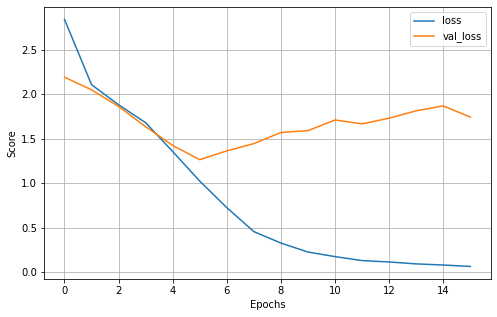

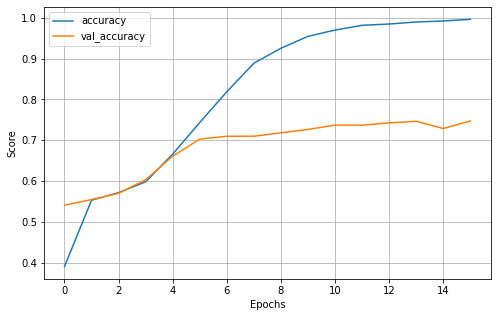

In [29]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.2 Modelo n.2: 1 bloco VGG com Nadam

### 2.2.1 Criação do modelo

In [30]:
model_vgg1_nadam = Sequential(layers=[
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001), input_shape=(100,100,3)),
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(83, activation='softmax')
])
opt = tf.keras.optimizers.Nadam(learning_rate=0.01 )
model_vgg1_nadam.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### 2.2.2 Treinamento

In [31]:
history_nadam = None
with tf.device('/GPU:0'):
    history_nadam = model_vgg1_nadam.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100


2022-06-16 10:16:36.263422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - ETA: 0s - loss: 5.0450 - accuracy: 0.0380

2022-06-16 10:17:54.869705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - 86s 110ms/step - loss: 5.0450 - accuracy: 0.0380 - val_loss: 4.0218 - val_accuracy: 0.0980
Epoch 2/100
762/762 [==============================] - 81s 105ms/step - loss: 3.3442 - accuracy: 0.2443 - val_loss: 2.6106 - val_accuracy: 0.4065
Epoch 3/100
762/762 [==============================] - 79s 103ms/step - loss: 2.3965 - accuracy: 0.4591 - val_loss: 2.5410 - val_accuracy: 0.4699
Epoch 4/100
762/762 [==============================] - 79s 103ms/step - loss: 2.1081 - accuracy: 0.5178 - val_loss: 2.1324 - val_accuracy: 0.5083
Epoch 5/100
762/762 [==============================] - 79s 104ms/step - loss: 1.8963 - accuracy: 0.5533 - val_loss: 2.0426 - val_accuracy: 0.5280
Epoch 6/100
762/762 [==============================] - 79s 104ms/step - loss: 1.7652 - accuracy: 0.5735 - val_loss: 1.9500 - val_accuracy: 0.5429
Epoch 7/100
762/762 [==============================] - 79s 103ms/step - loss: 1.7471 - accuracy: 0.5755 - val_loss: 2.0019 - val_accurac

Text(0, 0.5, 'Score')

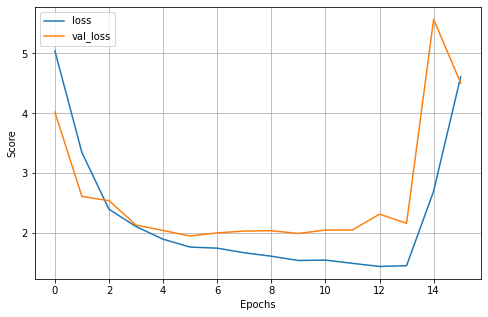

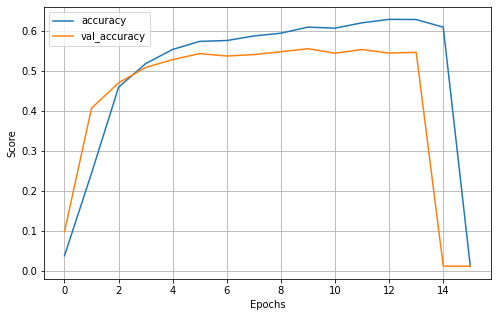

In [32]:
history_df = pd.DataFrame(history_nadam.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.3  Modelo n.3: 2 bloco VGG com SGD

### 2.3.1 Criação do modelo

In [33]:
model_vgg2 = Sequential(layers=[
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001), input_shape=(100,100,3)),
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(64,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001), input_shape=(100,100,3)),
    Conv2D(64,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(83, activation='softmax')
])
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, )
model_vgg2.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [34]:
model_vgg2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 64)       

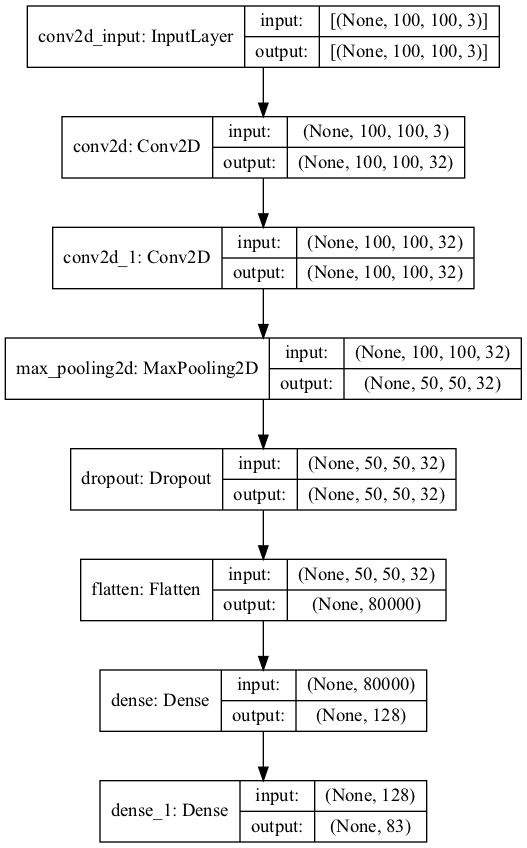

In [35]:
plot_model(model_vgg1, show_shapes=True)

### 2.3.2 Treinamento do modelo

In [36]:
history_vgg2 = None
with tf.device('/GPU:0'):
    history_vgg2 = model_vgg2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100


2022-06-16 10:46:02.403183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - ETA: 0s - loss: 3.6335 - accuracy: 0.2498

2022-06-16 10:47:09.710194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - 73s 93ms/step - loss: 3.6335 - accuracy: 0.2498 - val_loss: 2.5707 - val_accuracy: 0.4978
Epoch 2/100
762/762 [==============================] - 64s 84ms/step - loss: 2.4885 - accuracy: 0.5027 - val_loss: 2.3264 - val_accuracy: 0.5377
Epoch 3/100
762/762 [==============================] - 63s 83ms/step - loss: 2.2464 - accuracy: 0.5485 - val_loss: 2.2147 - val_accuracy: 0.5506
Epoch 4/100
762/762 [==============================] - 64s 83ms/step - loss: 2.1806 - accuracy: 0.5522 - val_loss: 2.1713 - val_accuracy: 0.5513
Epoch 5/100
762/762 [==============================] - 65s 85ms/step - loss: 2.1108 - accuracy: 0.5587 - val_loss: 2.1316 - val_accuracy: 0.5518
Epoch 6/100
762/762 [==============================] - 64s 85ms/step - loss: 2.0994 - accuracy: 0.5529 - val_loss: 2.1254 - val_accuracy: 0.5490
Epoch 7/100
762/762 [==============================] - 64s 84ms/step - loss: 2.0019 - accuracy: 0.5649 - val_loss: 1.9952 - val_accuracy: 0.55

Text(0, 0.5, 'Score')

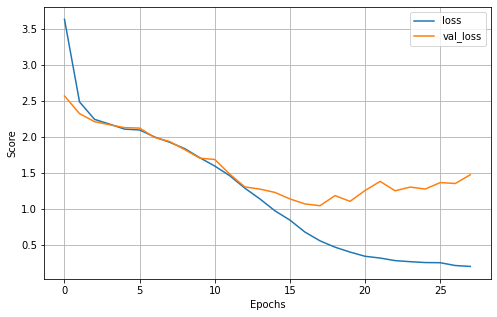

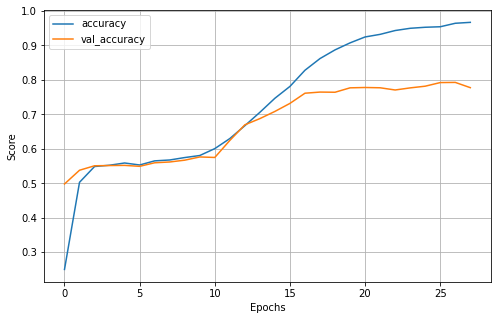

In [37]:
history_df = pd.DataFrame(history_vgg2.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.4 Modelo n.4: 2 bloco VGG com Nadam

### 2.4.1 Criação do modelo

In [38]:
model_vgg2_nadam = Sequential(layers=[
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001), input_shape=(100,100,3)),
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(64,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001), input_shape=(100,100,3)),
    Conv2D(64,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(83, activation='softmax')
])
opt = tf.keras.optimizers.Nadam(learning_rate=0.01, )
model_vgg2_nadam.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [39]:
model_vgg2_nadam.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 64)       

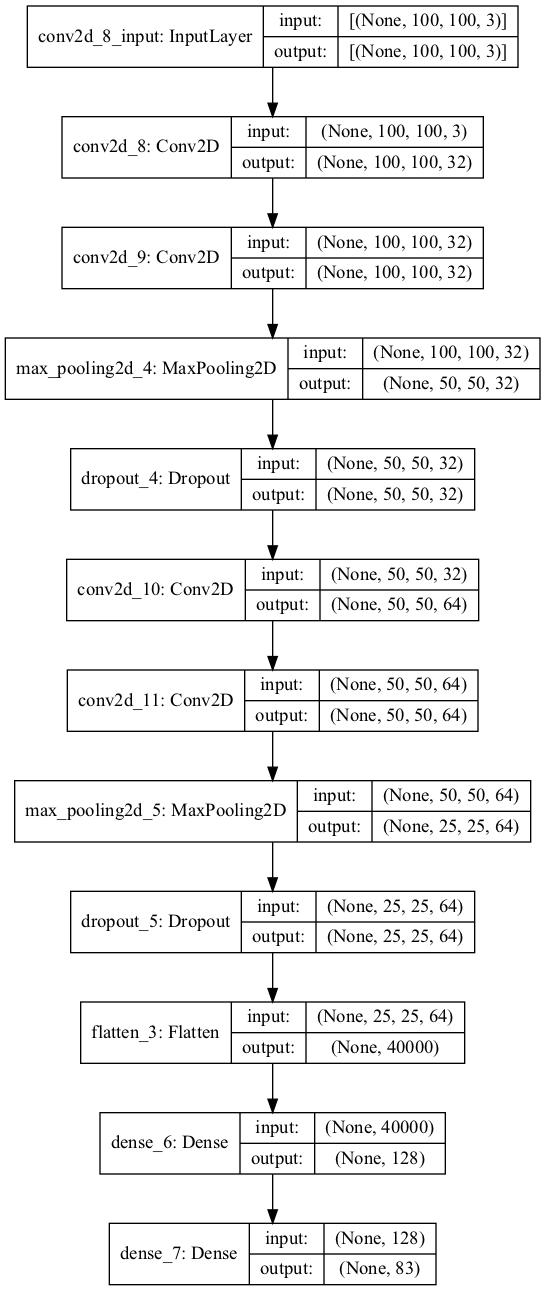

In [40]:
plot_model(model_vgg2_nadam, show_shapes=True)

### 2.4.2 Treinamento do modelo

In [41]:
history_vgg2_nadam = None
with tf.device('/GPU:0'):
    history_vgg2_nadam = model_vgg2_nadam.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100


2022-06-16 11:18:50.619680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - ETA: 0s - loss: 4.7606 - accuracy: 0.0112

2022-06-16 11:20:12.930371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - 89s 112ms/step - loss: 4.7606 - accuracy: 0.0112 - val_loss: 4.5155 - val_accuracy: 0.0120
Epoch 2/100
762/762 [==============================] - 76s 99ms/step - loss: 4.4976 - accuracy: 0.0101 - val_loss: 4.4776 - val_accuracy: 0.0120
Epoch 3/100
762/762 [==============================] - 77s 101ms/step - loss: 4.4689 - accuracy: 0.0114 - val_loss: 4.4557 - val_accuracy: 0.0120
Epoch 4/100
762/762 [==============================] - 77s 101ms/step - loss: 4.4503 - accuracy: 0.0117 - val_loss: 4.4414 - val_accuracy: 0.0120
Epoch 5/100
762/762 [==============================] - 82s 107ms/step - loss: 4.4389 - accuracy: 0.0104 - val_loss: 4.4313 - val_accuracy: 0.0120
Epoch 6/100
762/762 [==============================] - 96s 126ms/step - loss: 4.4312 - accuracy: 0.0112 - val_loss: 4.4259 - val_accuracy: 0.0121
Epoch 7/100
762/762 [==============================] - 79s 104ms/step - loss: 4.4275 - accuracy: 0.0109 - val_loss: 4.4230 - val_accuracy

Text(0, 0.5, 'Score')

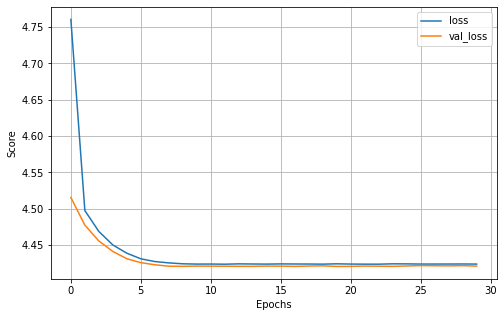

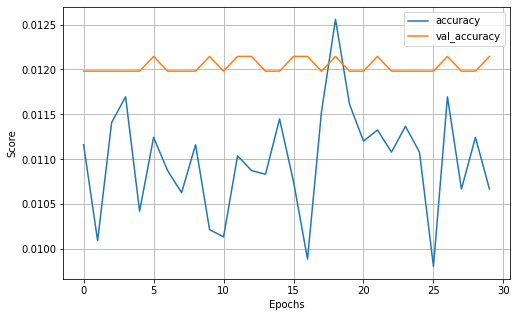

In [42]:
history_df = pd.DataFrame(history_vgg2_nadam.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.5 Modelo n.5: Transfer learning VGG16 com SGD

### 2.5.1 Criação do modelo

In [44]:
base_vgg = VGG16(include_top=None,  
                   weights="imagenet", 
                   input_shape=(100, 100, 3))  
base_vgg.trainable = False

In [45]:
model_vgg_sgd = Sequential([
    base_vgg,
    
    Flatten(),
    
    Dense(254, activation='relu'),
    
    Dense(128, activation='relu'),
    
    Dense(83, activation='softmax')
])

opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, )
model_vgg_sgd.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [46]:
model_vgg_sgd.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 254)               1170686   
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32640     
_________________________________________________________________
dense_10 (Dense)             (None, 83)                10707     
Total params: 15,928,721
Trainable params: 1,214,033
Non-trainable params: 14,714,688
_________________________________________________________________


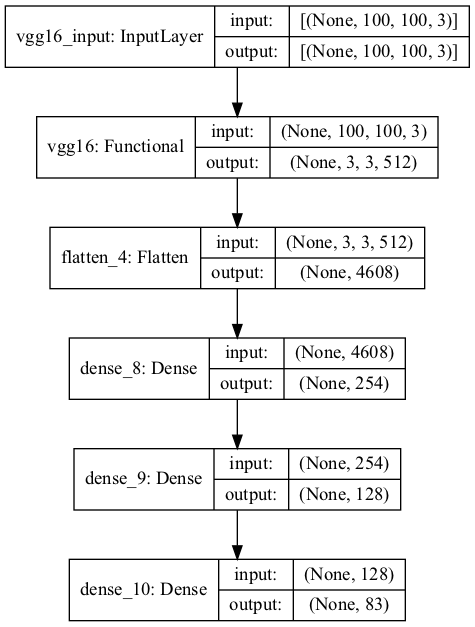

In [47]:
plot_model(model_vgg_sgd, show_shapes=True)

### 2.5.1 Treinamento do modelo

In [49]:
history_vgg_sgd = None
with tf.device('/GPU:0'):
    history_vgg_sgd = model_vgg_sgd.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100
762/762 [==============================] - 132s 172ms/step - loss: 0.4947 - accuracy: 0.8579 - val_loss: 1.9142 - val_accuracy: 0.6954
Epoch 2/100
762/762 [==============================] - 139s 183ms/step - loss: 0.5184 - accuracy: 0.8528 - val_loss: 2.3541 - val_accuracy: 0.6575
Epoch 3/100
762/762 [==============================] - 152s 200ms/step - loss: 0.5476 - accuracy: 0.8477 - val_loss: 2.3478 - val_accuracy: 0.6703
Epoch 4/100
762/762 [==============================] - 163s 213ms/step - loss: 0.4893 - accuracy: 0.8590 - val_loss: 2.0163 - val_accuracy: 0.6900
Epoch 5/100
762/762 [==============================] - 185s 243ms/step - loss: 0.4829 - accuracy: 0.8614 - val_loss: 2.1360 - val_accuracy: 0.6974
Epoch 6/100
762/762 [==============================] - 188s 247ms/step - loss: 0.5433 - accuracy: 0.8513 - val_loss: 1.9490 - val_accuracy: 0.6941
Epoch 7/100
762/762 [==============================] - 191s 251ms/step - loss: 0.4824 - accuracy: 0.8607 - val_loss: 2

Text(0, 0.5, 'Score')

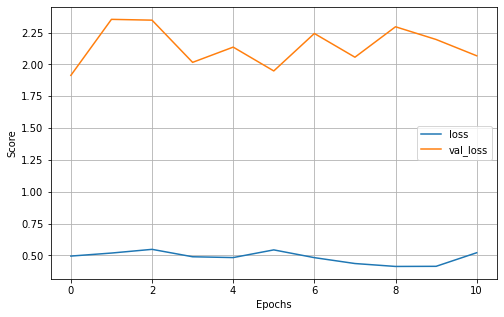

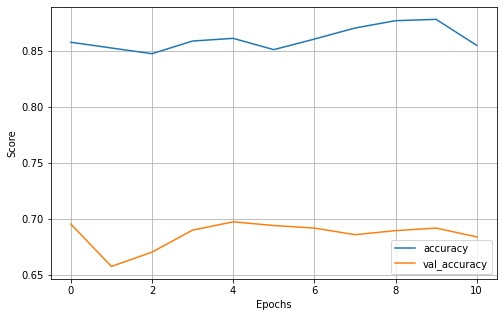

In [50]:
history_df = pd.DataFrame(history_vgg_sgd.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.6 Modelo n.6: Transfer learning com Nadam

### 2.6.1 Criação do modelo

In [52]:
model_vgg_nadam = Sequential([
    base_vgg,
    
    Flatten(),
    
    Dense(254, activation='relu'),
    
    Dense(128, activation='relu'),
    
    Dense(83, activation='softmax')
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.01,  )
model_vgg_nadam.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [53]:
model_vgg_nadam.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 254)               1170686   
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32640     
_________________________________________________________________
dense_13 (Dense)             (None, 83)                10707     
Total params: 15,928,721
Trainable params: 1,214,033
Non-trainable params: 14,714,688
_________________________________________________________________


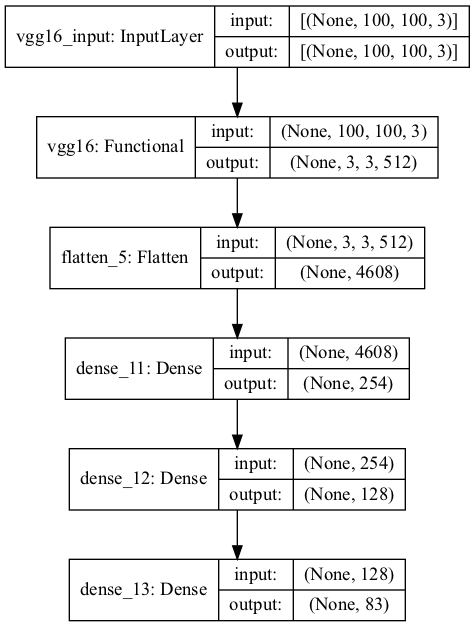

In [54]:
plot_model(model_vgg_nadam, show_shapes=True)

### 2.6.2 Treinamento do modelo

In [55]:
history_vgg_nadam = None
with tf.device('/GPU:0'):
    history_vgg_nadam = model_vgg_nadam.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100


2022-06-16 18:08:43.483290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - ETA: 0s - loss: 2.4235 - accuracy: 0.4296

2022-06-16 18:10:41.558111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - 147s 186ms/step - loss: 2.4235 - accuracy: 0.4296 - val_loss: 1.9711 - val_accuracy: 0.5382
Epoch 2/100
762/762 [==============================] - 148s 195ms/step - loss: 1.9583 - accuracy: 0.5295 - val_loss: 1.9115 - val_accuracy: 0.5367
Epoch 3/100
762/762 [==============================] - 153s 201ms/step - loss: 1.9183 - accuracy: 0.5398 - val_loss: 2.2513 - val_accuracy: 0.5032
Epoch 4/100
762/762 [==============================] - 157s 206ms/step - loss: 1.9803 - accuracy: 0.5394 - val_loss: 1.8914 - val_accuracy: 0.5496
Epoch 5/100
762/762 [==============================] - 159s 208ms/step - loss: 1.9534 - accuracy: 0.5486 - val_loss: 2.3168 - val_accuracy: 0.5355
Epoch 6/100
762/762 [==============================] - 159s 208ms/step - loss: 1.8385 - accuracy: 0.5584 - val_loss: 2.2872 - val_accuracy: 0.5377
Epoch 7/100
762/762 [==============================] - 163s 213ms/step - loss: 2.0726 - accuracy: 0.5438 - val_loss: 2.0710 - val_

Text(0, 0.5, 'Score')

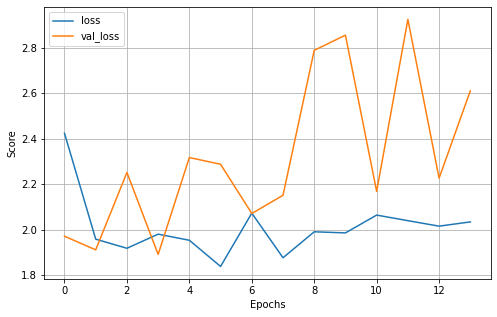

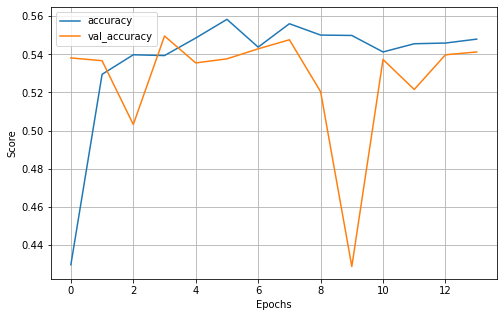

In [56]:
history_df = pd.DataFrame(history_vgg_nadam.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')


## 2.7 Salvando os modelos

In [58]:
model_vgg1.save('./models/one-block-vgg-sgd.h5')
model_vgg1_nadam.save('./models/one-block-vgg-nadam.h5')
model_vgg2.save('./models/two-blocks-vgg-sgd.h5')
model_vgg2_nadam.save('./models/two-blocks-vgg-nadam.h5')
model_vgg_sgd.save('./models/transfer-vgg-sgd.h5')
model_vgg_nadam.save('./models/transfer-vgg-nadam.h5')

# 3. Validação

In [59]:
print(f'Evaluate 1VGG +sgd: {model_vgg1.evaluate(X_test, y_test)}')
print(f'Evaluate 1VGG +nadam: {model_vgg1_nadam.evaluate(X_test, y_test)}')

print(f'Evaluate 2VGG +sgd: {model_vgg2.evaluate(X_test, y_test)}')
print(f'Evaluate 2VGG +nadam: {model_vgg2_nadam.evaluate(X_test, y_test)}')
      
print(f'Evaluate VGG16 +sgd: {model_vgg_sgd.evaluate(X_test, y_test)}')
print(f'Evaluate VGG16 +nadam: {model_vgg_nadam.evaluate(X_test, y_test)}')

52/52 [==============================] - 3s 44ms/step - loss: 1.6285 - accuracy: 0.5801
Evaluate 1VGG +sgd: [1.628454566001892, 0.5801205039024353]
52/52 [==============================] - 2s 41ms/step - loss: 3.5918 - accuracy: 0.1048
Evaluate 1VGG +nadam: [3.5918030738830566, 0.10481928288936615]
52/52 [==============================] - 2s 29ms/step - loss: 1.0010 - accuracy: 0.7693
Evaluate 2VGG +sgd: [1.0010085105895996, 0.7692770957946777]
52/52 [==============================] - 2s 30ms/step - loss: 4.4206 - accuracy: 0.0120
Evaluate 2VGG +nadam: [4.420633316040039, 0.012048193253576756]
52/52 [==============================] - 7s 127ms/step - loss: 1.4950 - accuracy: 0.6566
Evaluate VGG16 +sgd: [1.4949824810028076, 0.6566265225410461]
52/52 [==============================] - 6s 123ms/step - loss: 3.8697 - accuracy: 0.0392
Evaluate VGG16 +nadam: [3.8697218894958496, 0.03915662690997124]


In [68]:
y_vgg1 = model_vgg1.predict(X_test)
y_vgg1_nadam = model_vgg1_nadam.predict(X_test)

y_vgg2 = model_vgg2.predict(X_test)
y_vgg2_nadam = model_vgg2_nadam.predict(X_test)

y_vgg = model_vgg_sgd.predict(X_test)
y_vgg_nadam = model_vgg_nadam.predict(X_test)

In [69]:
from sklearn.metrics import accuracy_score

In [70]:
y_vgg1 = np.argmax(y_vgg1, axis=1)
y_vgg1_nadam = np.argmax(y_vgg1_nadam, axis=1)
y_vgg2 = np.argmax(y_vgg2, axis=1)
y_vgg2_nadam = np.argmax(y_vgg2_nadam, axis=1)
y_vgg = np.argmax(y_vgg, axis=1)
y_vgg_nadam = np.argmax(y_vgg_nadam, axis=1)

In [72]:
print(f'Accuracy 1VGG +sgd: {round(accuracy_score( y_test,y_vgg1),2)}')
print(f'Accuracy 1VGG +nadam: {round(accuracy_score(y_test, y_vgg1_nadam),2)}')

print(f'Accuracy 2VGG +sgd: {round(accuracy_score(y_test, y_vgg2),2)}')
print(f'Accuracy 2VGG +nadam: {round(accuracy_score(y_test, y_vgg2_nadam),2)}')
      
print(f'Accuracy VGG16 +sgd: {round(accuracy_score(y_test, y_vgg),2)}')
print(f'Accuracy VGG16 +nadam: {round(accuracy_score(y_test, y_vgg_nadam),2)}')

Accuracy 1VGG +sgd: 0.58
Accuracy 1VGG +nadam: 0.1
Accuracy 2VGG +sgd: 0.77
Accuracy 2VGG +nadam: 0.01
Accuracy VGG16 +sgd: 0.66
Accuracy VGG16 +nadam: 0.04
